# Analyzing Boston Marathon Data Through Clustering

In this study, clustering techniques were used on data from the 2014 Boston Marathon to gain an understanding of how different observations may be related. These techniques focused on utilizing factors related to the individual participants in the event. Sillhouette scores were used to evaluate clusters and analysis was done on individual clusters to better ascertain how divisions were made.

In [1]:
%%time

import math
import re
import warnings

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="sklearn"  
    )


# Set Plot Style
sns.set_style('darkgrid')


CPU times: user 1.62 s, sys: 574 ms, total: 2.2 s
Wall time: 3.15 s


In [2]:
## Import Data

df = pd.read_csv("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv", header=None, error_bad_lines=False)

In [3]:
## View Data for Cleaning

#df.head(7)
#df.dtypes
#df.describe()
#df.isnull().sum(axis = 0)
#len(df)

In [4]:
## Rename Columns

df.columns = list(df.iloc[0,:])
df = df.drop(df.index[0])
df = df.reset_index(drop=True)

In [5]:
## Change Data Types

df = df.apply(pd.to_numeric, errors='ignore')
df[['10k', '25k','35k','30k',
    '5k','half','20k','40k']] = df[['10k', '25k','35k','30k',
                                    '5k','half','20k','40k']].apply(pd.to_numeric, errors='coerce')

In [6]:
## Drop Null Values

df = df.drop('ctz',axis=1).dropna()
df = df.reset_index(drop=True)


## Initial Data Analysis


In [7]:
df.head(7)

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,30.480,"Hall, Ryan",20,77.680,M,31,137.830,6,20,112.270,20,5.270,CA,94.780,15.150,65.230,61.780,USA,Redding,129.830
1,17.120,"Cassidy, Josh R.",13,48.880,M,29,87.400,W8,13,72.830,13,3.350,ON,60.820,8.020,40.200,38.020,CAN,Port Elgin,82.380
2,33.930,"Linden, Desiree",10,85.030,F,30,143.900,F8,10,119.680,46,5.500,MI,102.400,16.920,71.680,67.920,USA,Rochester Hills,136.470
3,18.300,"Filteau, Michel",14,50.330,M,47,89.400,W13,14,74.950,14,3.420,QC,62.330,8.670,41.800,39.630,CAN,St-Jean Baptiste,84.480
4,18.780,"Kim, Gyu Dae",15,50.330,M,30,89.520,W14,15,75.020,15,3.420,IL,62.720,8.980,41.820,39.650,USA,Champaign,84.750
5,18.750,"George, Joshua",6,49.150,M,30,84.820,W15,6,70.830,6,3.250,IL,59.920,8.930,41.180,39.080,USA,Champaign,80.180
6,32.570,"Flanagan, Shalane",7,82.430,F,32,142.030,F17,7,116.630,37,5.430,OR,99.330,16.200,69.450,65.820,USA,Portland,134.000


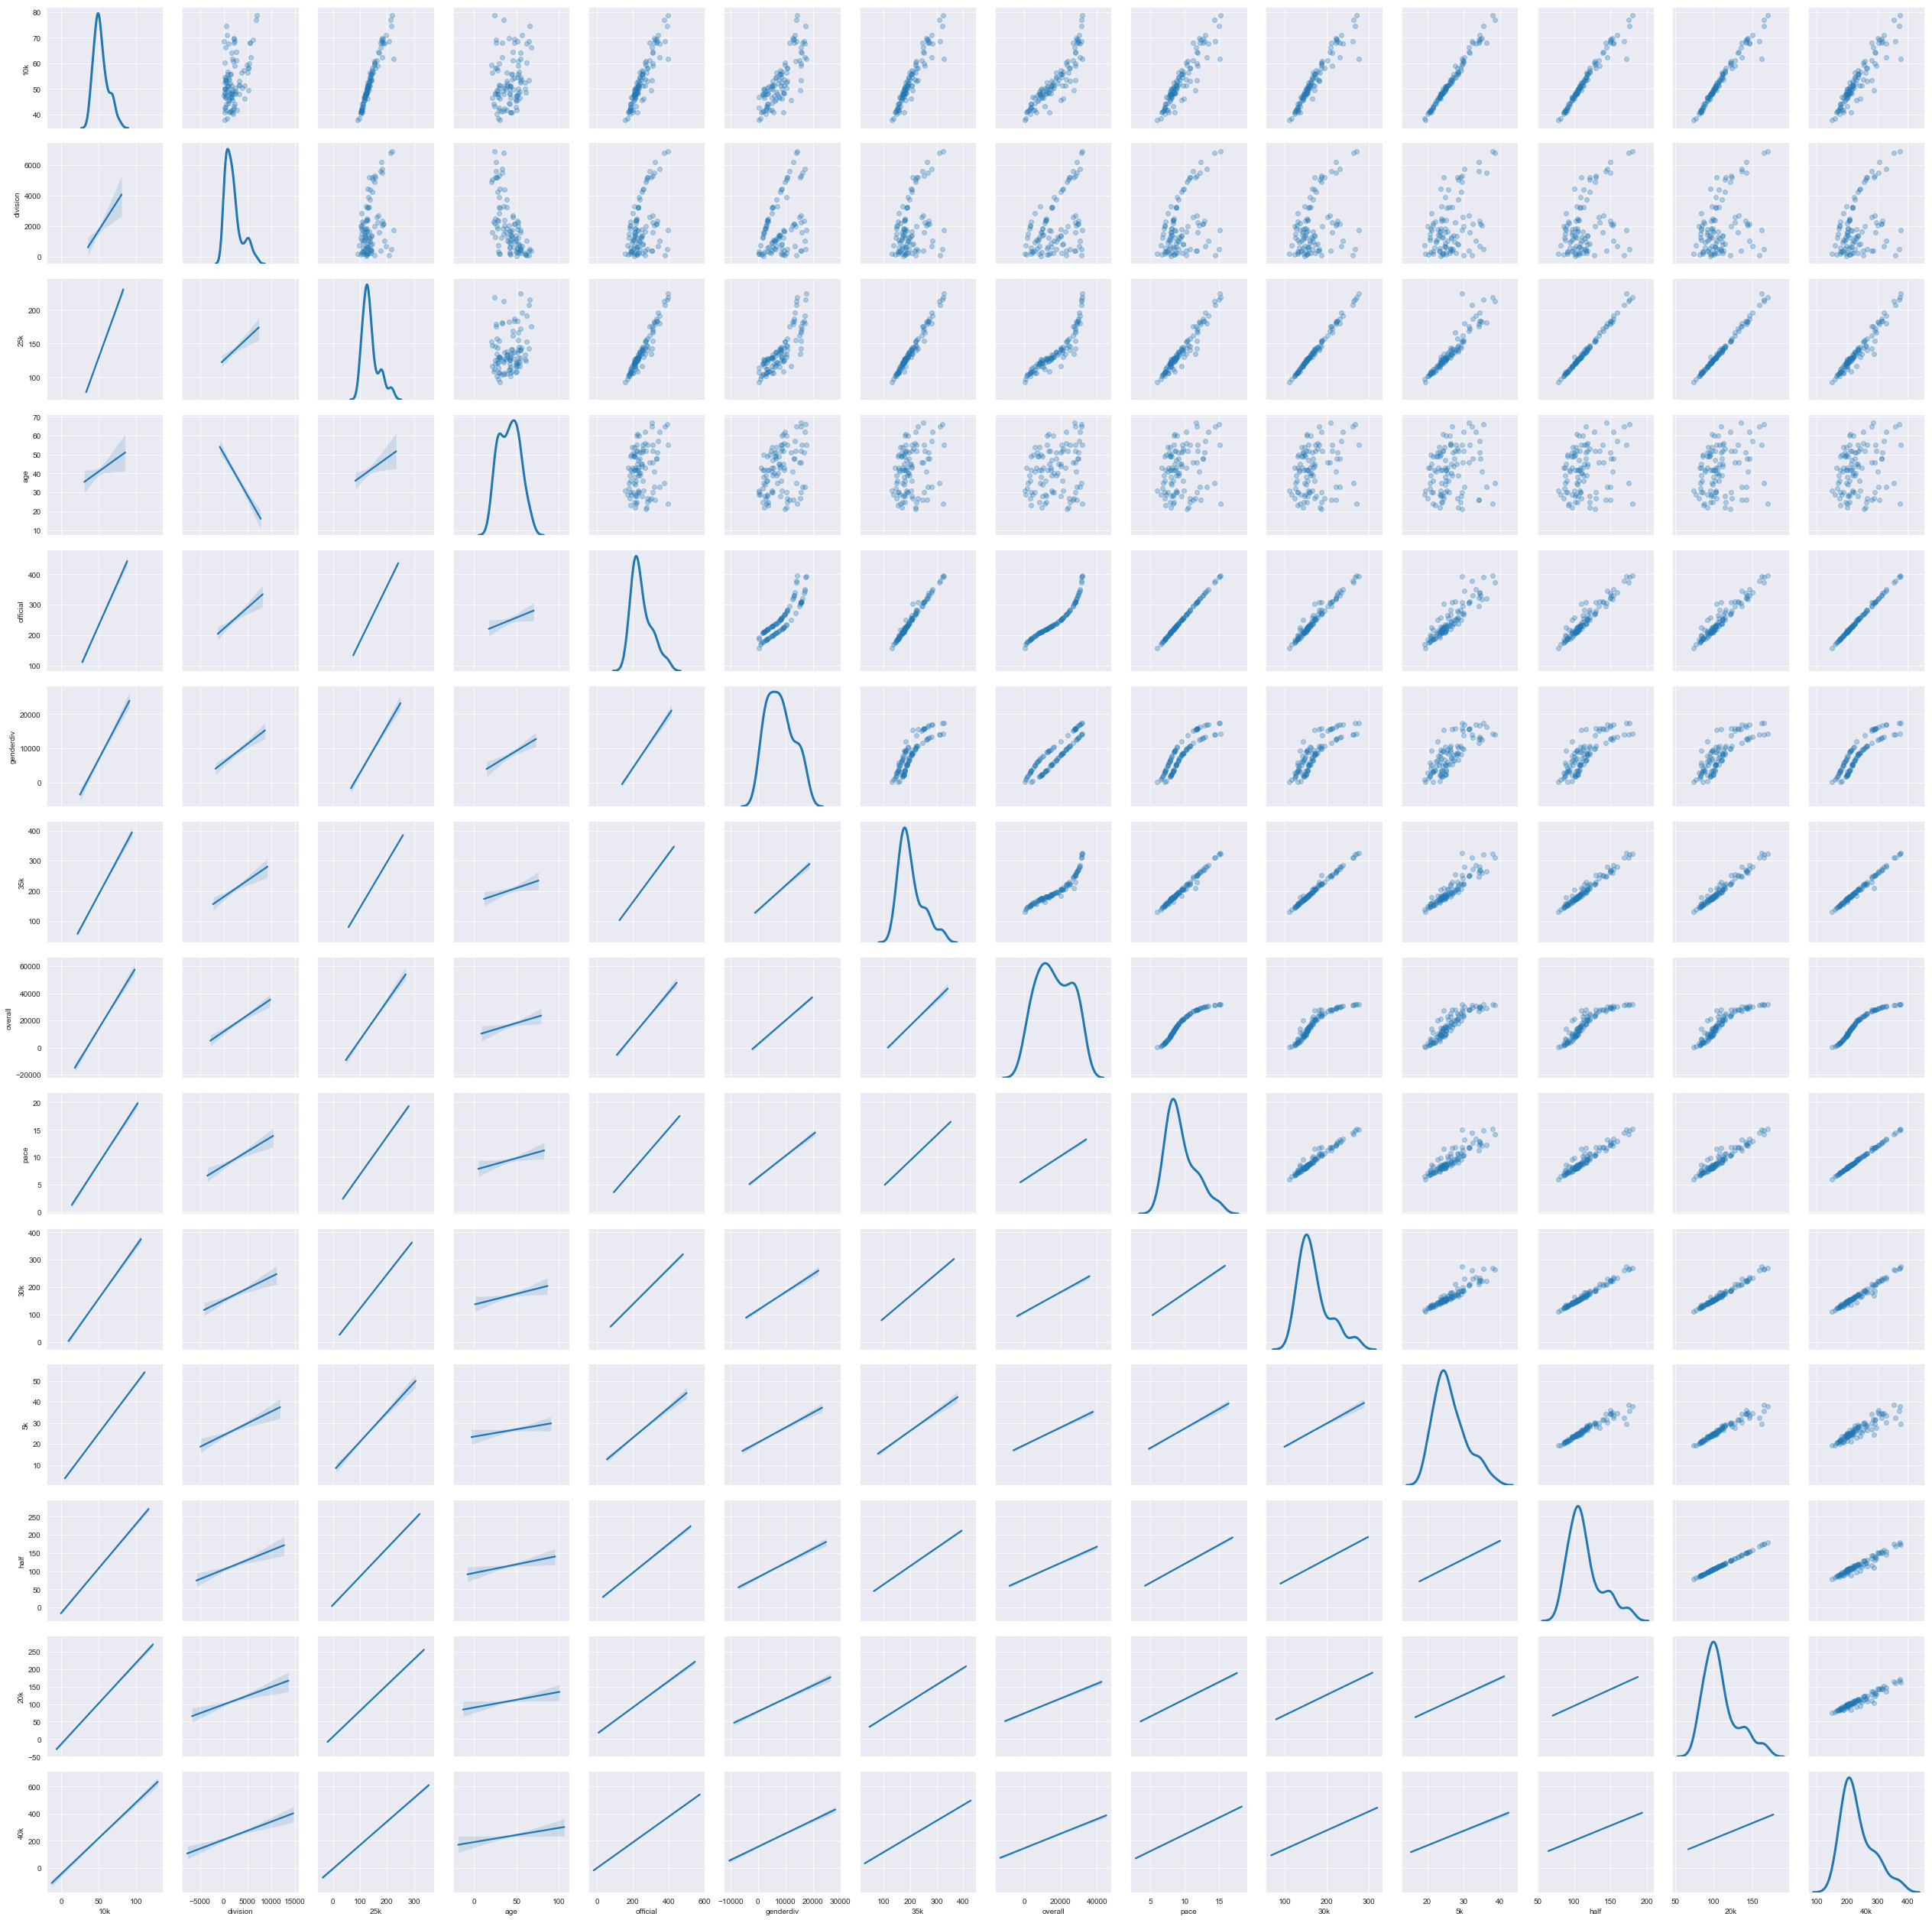

CPU times: user 1min 2s, sys: 5.6 s, total: 1min 8s
Wall time: 31.8 s


In [8]:
%%time

### Creating Scatterplot Matrix with Sample of DataFrame

## Store samples of DataFrame For Visualization

df_sample = df.sample(100)

## Declare Pairgrid
g = sns.PairGrid(df_sample.dropna().drop('bib',axis=1), diag_sharey=False)

## Scatterplot
g.map_upper(plt.scatter, alpha=.3)

## Fit line 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

## KDE plot
g.map_diag(sns.kdeplot, lw=3)
plt.show()

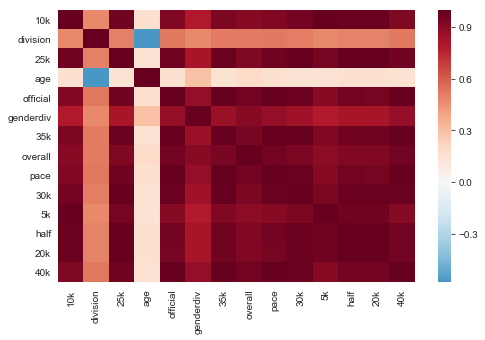

In [9]:

## Visualizing the Correlatedness of the Continuous variables

fig, ax = plt.subplots(figsize=(8,5))         
sns.heatmap(df.corr(), cmap='RdBu_r', center=0)
plt.show()

Large amounts of the variables were correlated since the performances in each event were directly related.

In [10]:
print('Length of dataframe: ' + str(len(df)) + '\n')
print('Number of unique name values: ' + str(df.name.nunique()))
print('Number of unique official values: ' + str(df.official.nunique()))
print('Number of unique bib values: ' + str(df.bib.nunique()))
print('Number of unique country values: ' + str(df.country.nunique()))
print('Number of unique city values: ' + str(df.city.nunique()))

Length of dataframe: 29103

Number of unique name values: 29044
Number of unique official values: 10568
Number of unique bib values: 29103
Number of unique country values: 2
Number of unique city values: 4648


Variables with very large numbers of classes may not be palatable to clustering methods.

In [11]:
df.gender.value_counts()

M    15578
F    13525
Name: gender, dtype: int64

In [12]:
df.country.value_counts()

USA    26939
CAN     2164
Name: country, dtype: int64

In [13]:
%%time
## Descriptive Statistics of All Continuous Variables
df.describe()

CPU times: user 69.2 ms, sys: 8.31 ms, total: 77.5 ms
Wall time: 55.9 ms


,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000
mean,51.827,1966.941,134.107,42.054,242.813,8008.426,196.772,15980.929,9.269,164.525,25.779,111.640,105.729,229.038
std,8.704,1732.203,25.628,11.348,50.922,4733.456,40.870,9169.894,1.942,32.965,4.207,20.334,19.186,48.165
min,17.120,1.000,48.550,18.000,84.820,1.000,70.830,1.000,3.250,59.770,8.020,40.200,38.020,80.180
25%,45.580,623.500,115.920,33.000,205.980,3954.500,167.550,8074.500,7.870,141.075,22.730,97.180,92.070,194.280
50%,50.430,1445.000,129.230,42.000,232.570,7923.000,188.400,15997.000,8.880,157.980,25.150,108.020,102.350,219.120
75%,57.200,2703.500,148.430,50.000,273.310,11908.500,220.270,23946.000,10.430,183.125,28.500,123.200,116.650,257.780
max,112.380,6979.000,289.020,81.000,538.880,17575.000,449.330,31931.000,20.570,376.380,86.950,236.670,224.350,508.350


## Preparing The Data For Clustering

In [14]:
%%time

## Remove Columns With Low Significance

df = df.drop(['name', 'official', 'bib', 'city'] ,axis=1)

CPU times: user 2.27 ms, sys: 235 µs, total: 2.5 ms
Wall time: 2.47 ms


These variables were dropped because they had a large number of unique classes and wouldn't serve as a good basis to make distinctions.

In [15]:
%%time

## Store Data and Create Training and Testing Groups

X = df

X_train_, X_test_= train_test_split(
    X,
    test_size=0.2,
    random_state=42)

X_train = pd.get_dummies(X_train_)
X_test = pd.get_dummies(X_test_)

## Display New Number of Features

print('Number of Features: '+ str(len(X_train.columns)))

Number of Features: 84
CPU times: user 42.4 ms, sys: 5.81 ms, total: 48.2 ms
Wall time: 47.7 ms


The increase in features came as a result of the state variables being turned into dummies.

## Using Clustering Methods to Label the Datasets

### Mean Shift

In [16]:
%%time

bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}\n".format(n_clusters_))

Number of estimated clusters: 2

CPU times: user 18.1 s, sys: 382 ms, total: 18.5 s
Wall time: 18.6 s


In [17]:
%%time

## Computing a Sillhouette Score For the Mean Shift

print('Silhouette Score for Mean Shift with 2 Clusters: ' + str(silhouette_score(X_train, labels)) + '\n')

Silhouette Score for Mean Shift with 2 Clusters: 0.48946078123171577

CPU times: user 12.3 s, sys: 1.69 s, total: 14 s
Wall time: 8.95 s


### K Means

In [18]:
%%time

## Choosing Appropriate Number of Clusters

print('Silhouette scores for K Means:\n')
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    print(str(n_clusters) + ' clusters: ' + str(silhouette_score(X_train, KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X_train))))
print('\n')

Silhouette scores for K Means:

2 clusters: 0.5740618914389091
3 clusters: 0.4964724184220665
4 clusters: 0.4380862592380197
5 clusters: 0.39158331261513585
6 clusters: 0.3546366444540107


CPU times: user 1min 21s, sys: 11.5 s, total: 1min 33s
Wall time: 51.9 s


Mean Shift settled on two clusters and the silhouette score for K means was highest when it had two clusters. However, in order to be able to learn more about the dataset, more clusters would be needed. For this reason 4 clusters would be appropriate for analyzing the dataset. The range in sillhouette scores showed a decrease in similarity among datapotnts as the number of clusters increased, which would be natural because an increased number of clusters would mean that each cluster is smaller and further apart. Since the the sillhouette score that resulted from clustering using K means with 4 clusters was still reasonably high, the data will be analyzed with respect to divisions made using this method.

## Analyzing Clusters Made Using K Means

In [19]:
%%time

## Calculate predicted values.

y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_train)

CPU times: user 4.08 s, sys: 510 ms, total: 4.59 s
Wall time: 1.24 s


In [48]:
%%time

## Create A Dataframe Using The Original Dataset and New Labels

df_kmeans = X_train_
df_kmeans['labels'] = y_pred

## Split Results by New Labels

df_kmeans_0 = df_kmeans.loc[df_kmeans['labels'] == 0]
df_kmeans_1 = df_kmeans.loc[df_kmeans['labels'] == 1]
df_kmeans_2 = df_kmeans.loc[df_kmeans['labels'] == 2]
df_kmeans_3 = df_kmeans.loc[df_kmeans['labels'] == 3]

### Create Dataframes for Visualization

## Create Index
cluster_names = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

## Create Dataframe for Gender
genders = {'male':[len(df_kmeans_0.gender.loc[df['gender'] == 'M']),
len(df_kmeans_1.gender.loc[df['gender'] == 'M']),
len(df_kmeans_2.gender.loc[df['gender'] == 'M']),
len(df_kmeans_3.gender.loc[df['gender'] == 'M'])],
'female':[len(df_kmeans_0.gender.loc[df['gender'] == 'F']),
len(df_kmeans_1.gender.loc[df['gender'] == 'F']),
len(df_kmeans_2.gender.loc[df['gender'] == 'F']),
len(df_kmeans_3.gender.loc[df['gender'] == 'F'])]}

df_genders_by_cluster = pd.DataFrame(genders, index = cluster_names)

## Create Dataframe for Ages
ages = {'30 or less' :[len(df_kmeans_0.age.loc[df['age'] <= 30]),
len(df_kmeans_1.age.loc[df['age'] <= 30]),
len(df_kmeans_2.age.loc[df['age'] <= 30]),
len(df_kmeans_3.age.loc[df['age'] <= 30])],
'30 to 40' :[len(df_kmeans_0.age.loc[df['age'] <= 40].loc[df['age'] > 30]),
len(df_kmeans_1.age.loc[df['age'] <= 40].loc[df['age'] > 30]),
len(df_kmeans_2.age.loc[df['age'] <= 40].loc[df['age'] > 30]),
len(df_kmeans_3.age.loc[df['age'] <= 40].loc[df['age'] > 30])],
'40 to 50' :[len(df_kmeans_0.age.loc[df['age'] <= 50].loc[df['age'] > 40]),
len(df_kmeans_1.age.loc[df['age'] <= 50].loc[df['age'] > 40]),
len(df_kmeans_2.age.loc[df['age'] <= 50].loc[df['age'] > 40]),
len(df_kmeans_3.age.loc[df['age'] <= 50].loc[df['age'] > 40])],
'50 to 60' :[len(df_kmeans_0.age.loc[df['age'] <= 60].loc[df['age'] > 50]),
len(df_kmeans_1.age.loc[df['age'] <= 60].loc[df['age'] > 50]),
len(df_kmeans_2.age.loc[df['age'] <= 60].loc[df['age'] > 50]),
len(df_kmeans_3.age.loc[df['age'] <= 60].loc[df['age'] > 50])],
'60 and over' :[len(df_kmeans_0.age.loc[df['age'] > 60]),
len(df_kmeans_1.age.loc[df['age'] > 60]),
len(df_kmeans_2.age.loc[df['age'] > 60]),
len(df_kmeans_3.age.loc[df['age'] > 60])]}

df_ages_by_cluster = pd.DataFrame(ages, index = cluster_names)

Cluster labels were assigned to the original dataset and that dataset was split by label for further analysis. Each cluster is referred to as  cluster 1, cluster 2, cluster 3 and cluster 4.

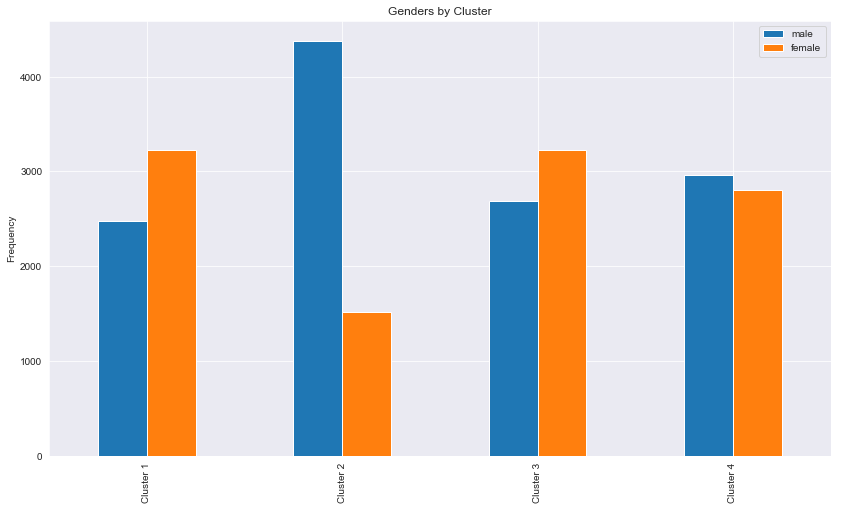

CPU times: user 696 ms, sys: 65 ms, total: 761 ms
Wall time: 316 ms


In [75]:
%%time

## Bar Graph for Genders

ax = df_genders_by_cluster.plot(kind='bar', title ="Genders by Cluster", figsize=(14, 8), legend=True)
ax.set_ylabel("Frequency")
plt.show()

Clusters were compared by the prevalence of each class in each cluster.
Cluster 2 had a disproportionately high number of males compared to the other clusters. 
Cluster 1 and 3 had more females than males.
Cluster 4 had a similar number of males and females.
Gender does serve as an indicator of what group an observation would fall into, making the feature a indicator of distinctions.

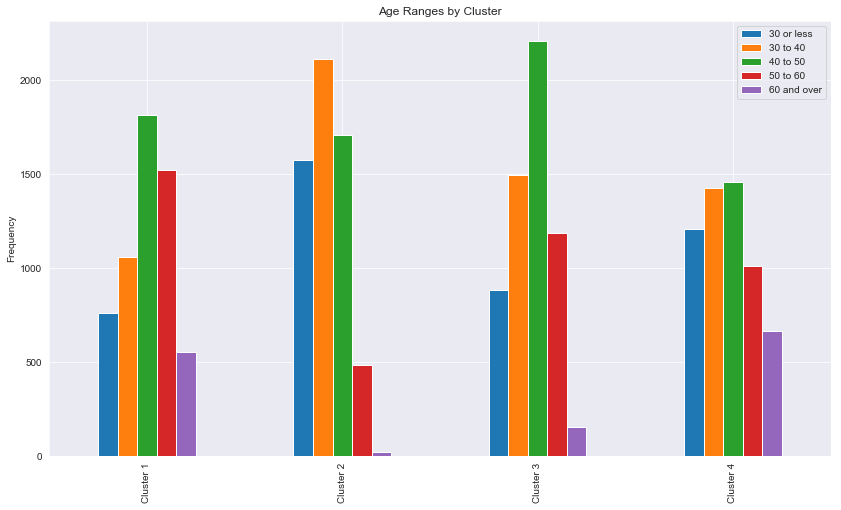

CPU times: user 767 ms, sys: 71.7 ms, total: 838 ms
Wall time: 373 ms


In [74]:
%%time

## Bar Graph for Ages

ax = df_ages_by_cluster.plot(kind='bar', title ="Age Ranges by Cluster", figsize=(14, 8),  legend=True)
ax.set_ylabel("Frequency")
plt.show()

Clusters were compared by the prevalence of each class in each cluster.
Clusters 2 and 4 had a higher number of young participants (ages 30 or less). 
Cluster 1 had a significantly lower number of participants ages 30 to 40.
Ages 40 through 50 were the most frequently occuring within the datataset and saw strong representation among all clusters.
Cluster 1 had a sharlply larger amount of participants ages 50 to 60.
There were significantly lower numbers of participants above age 60 to analyze but it could still be noted that the vast majority of them were in cluster 1 and 4.
Clustering has shown that there may be a relationship to males and younger age as can be seen through clusters 2 and 4. Older ages tend to have much higher occurences in cluster 1, the cluster with the most females as well.

In [76]:
## Describe Cluster 1
df_kmeans_0[['10k', 'division', '25k', 'age', 'genderdiv', '35k', 'overall', 'pace',
       '30k', '5k', 'half', '20k', '40k']].describe()

,10k,division,25k,age,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,5704.000,5704.000,5704.000,5704.000,5704.000,5704.000,5704.000,5704.000,5704.000,5704.000,5704.000,5704.000,5704.000
mean,53.757,2058.890,138.300,45.546,9816.527,202.905,20063.989,9.589,169.548,26.799,115.324,109.240,236.720
std,3.903,1534.714,8.824,11.526,1978.014,11.282,2423.797,0.485,10.192,2.067,7.629,7.300,12.194
min,36.870,1.000,97.220,18.000,6204.000,154.220,14979.000,8.730,121.430,18.350,79.900,75.630,185.220
25%,51.180,912.000,132.780,37.000,8154.750,194.845,18096.750,9.170,162.930,25.450,110.545,104.630,226.620
50%,53.870,1589.000,138.280,46.000,9958.500,201.975,20095.000,9.550,169.175,26.850,115.470,109.400,235.620
75%,56.220,3861.000,143.980,54.000,11369.250,211.150,22047.500,9.970,176.350,28.120,120.100,113.800,246.100
max,71.170,5068.000,187.120,81.000,13577.000,238.750,25013.000,10.750,212.380,38.220,162.680,154.150,265.970


In [77]:
## Describe Cluster 2
df_kmeans_1[['10k', 'division', '25k', 'age', 'genderdiv', '35k', 'overall', 'pace',
       '30k', '5k', 'half', '20k', '40k']].describe()

,10k,division,25k,age,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,5889.000,5889.000,5889.000,5889.000,5889.000,5889.000,5889.000,5889.000,5889.000,5889.000,5889.000,5889.000,5889.000
mean,42.412,914.633,106.857,37.412,2497.675,152.896,4096.418,7.145,129.433,21.238,89.878,85.201,176.624
std,3.566,804.792,8.657,9.032,1797.168,12.152,2441.319,0.568,10.371,1.831,7.322,6.949,14.049
min,17.120,1.000,48.550,18.000,1.000,70.830,1.000,3.250,59.770,8.020,40.200,38.020,80.180
25%,40.550,261.000,101.980,30.000,959.000,145.900,1986.000,6.800,123.620,20.320,85.830,81.330,168.280
50%,42.620,703.000,107.270,37.000,1956.000,154.370,4081.000,7.250,130.220,21.350,90.220,85.550,178.970
75%,44.780,1291.000,113.030,44.000,4030.000,161.950,6112.000,7.580,136.970,22.420,95.080,90.100,187.380
max,53.970,3070.000,127.380,66.000,6113.000,174.850,9112.000,8.000,150.850,27.680,109.170,104.150,198.680


In [78]:
## Describe Cluster 3
df_kmeans_2[['10k', 'division', '25k', 'age', 'genderdiv', '35k', 'overall', 'pace',
       '30k', '5k', 'half', '20k', '40k']].describe()

,10k,division,25k,age,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,5920.000,5920.000,5920.000,5920.000,5920.000,5920.000,5920.000,5920.000,5920.000,5920.000,5920.000,5920.000,5920.000
mean,48.418,1525.479,123.133,42.540,5876.159,178.195,12138.833,8.373,149.958,24.173,103.193,97.780,206.817
std,2.874,1104.603,6.411,10.008,2260.285,7.682,2487.643,0.317,7.225,1.509,5.623,5.378,8.010
min,36.800,1.000,95.400,18.000,1963.000,146.330,7223.000,7.750,117.020,18.300,79.430,75.080,180.980
25%,46.700,598.000,119.127,36.000,3930.250,172.915,10134.750,8.120,145.377,23.250,99.765,94.470,200.550
50%,48.530,1278.000,123.350,43.000,5914.500,178.070,12126.500,8.370,150.030,24.180,103.500,98.070,206.600
75%,50.280,2383.250,127.450,50.000,7805.500,183.755,14139.250,8.620,154.950,25.130,106.900,101.300,212.920
max,58.980,3820.000,145.370,75.000,9909.000,197.520,16954.000,9.000,170.180,31.730,123.520,116.820,223.930


In [79]:
## Describe Cluster 4
df_kmeans_3[['10k', 'division', '25k', 'age', 'genderdiv', '35k', 'overall', 'pace',
       '30k', '5k', 'half', '20k', '40k']].describe()

,10k,division,25k,age,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,5769.000,5769.000,5769.000,5769.000,5769.000,5769.000,5769.000,5769.000,5769.000,5769.000,5769.000,5769.000,5769.000
mean,62.937,3381.857,168.841,43.000,13989.079,254.254,27871.961,12.021,210.080,31.005,138.719,131.219,297.264
std,6.408,2137.419,19.082,13.036,1917.174,28.075,2301.340,1.247,23.837,3.055,15.185,14.356,31.343
min,41.650,2.000,112.230,18.000,10401.000,183.350,22939.000,10.180,140.520,20.470,87.380,82.730,237.570
25%,58.700,1695.000,155.420,32.000,12445.000,233.000,25959.000,11.020,193.080,29.050,128.230,121.330,272.450
50%,62.520,2491.000,165.730,42.000,13918.000,248.250,27931.000,11.770,205.520,30.850,136.720,129.380,290.680
75%,66.700,5488.000,180.500,52.000,15575.000,271.450,29850.000,12.820,224.550,32.750,147.550,139.570,316.680
max,102.820,6979.000,289.020,81.000,17575.000,449.330,31931.000,20.570,376.380,51.980,236.670,224.350,508.350


Mean performances generally were within one standard deviation of the median for both groups. Due to the nature of the data, there is a limit on how low values related to race times can be (due to physical limitations). In addition to this, large outliers do exist due to people who may have had significantly a harder time finishing an event. Overall, cluster 4 had higher performances across all events. Despite the generally younger demographic of cluster 2, the performances were generally lower than in the other clusters.

## Conclusion

Clustering with K means proved useful for making distinctions between different types of runners. One group had more more females and high performers; one group had a large number of males and low performers; one group had much older people and average performance, and the last group had the top performers and a similar number of males and females.  While there may be a relationship between these qualities, the groups didn't exclusively consist of people of a specific quality. 